In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from pickle import load
import pandas as pd


In [2]:
# Load Data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
index_train = np.load('index_train.npy', allow_pickle=True)
index_test = np.load('index_test.npy', allow_pickle=True)



In [3]:
# Define LSTM Model
def build_lstm_model(input_shape):
    """
    Builds and compiles an LSTM model for time series forecasting.

    Args:
        input_shape (tuple): The shape of the input data (timesteps, features).

    Returns:
        tf.keras.Model: Compiled LSTM model.
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2),
        LSTM(64, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model



In [4]:
# Initialize LSTM Model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
lstm_model = build_lstm_model(input_shape)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train LSTM Model
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Trains the LSTM model on the given data.

    Args:
        model (tf.keras.Model): The LSTM model.
        X_train (numpy.ndarray): Training input data.
        y_train (numpy.ndarray): Training target data.
        X_test (numpy.ndarray): Validation input data.
        y_test (numpy.ndarray): Validation target data.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for training.

    Returns:
        tf.keras.callbacks.History: Training history object.
    """

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return history



In [6]:
# Plot Training and Validation Losses
def plot_training_losses(history):
    """
    Plots the training and validation loss curves.

    Args:
        history (tf.keras.callbacks.History): History object returned by model.fit().
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
# Train the model
history = train_lstm_model(lstm_model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.1907 - mae: 0.3618 - val_loss: 0.0464 - val_mae: 0.1973
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0573 - mae: 0.1906 - val_loss: 0.0110 - val_mae: 0.0775
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0476 - mae: 0.1786 - val_loss: 0.0297 - val_mae: 0.1551
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0380 - mae: 0.1577 - val_loss: 0.0252 - val_mae: 0.1414
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0318 - mae: 0.1395 - val_loss: 0.0150 - val_mae: 0.1032
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0313 - mae: 0.1438 - val_loss: 0.0131 - val_mae: 0.0945
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0301 - mae: 0.1361 - val_loss: 0.0147 - val_mae: 0.1027
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0351 - mae: 0.1532 - val_loss: 0.0157 - val_mae: 0.1078
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0317 - mae: 0.1419 - 

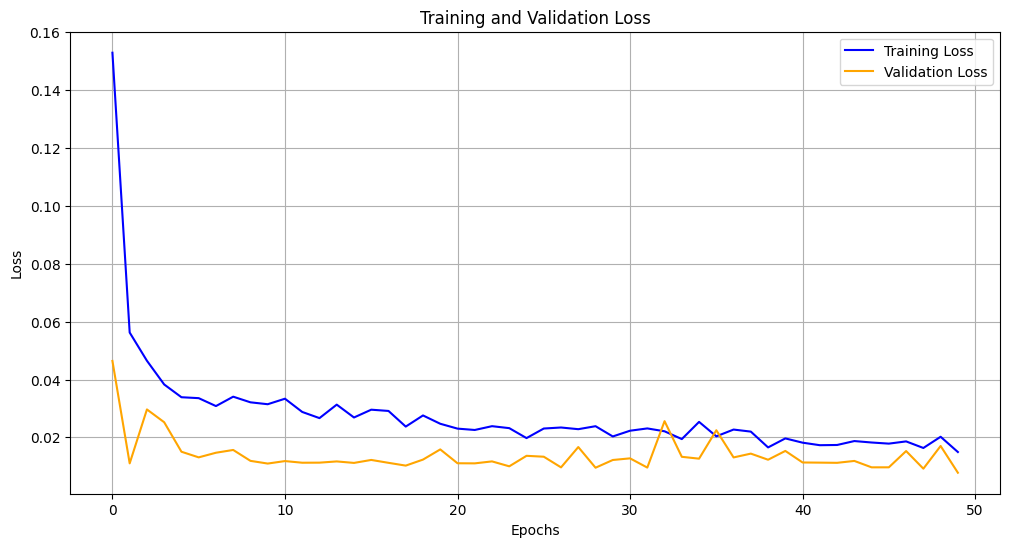

In [8]:
# Plot Training and Validation Losses
plot_training_losses(history)

In [9]:
# Evaluate Model
def evaluate_model(y_true, y_pred, index_test):
    """
    Evaluates the model's predictions using MSE, MAPE, and RMSE.
    Matches the logic from plot_test_data for RMSE calculation.

    Args:
        y_true (numpy.ndarray): The true target values.
        y_pred (numpy.ndarray): The predicted target values.
        index_test (numpy.ndarray): The index for test samples.

    Returns:
        dict: A dictionary containing MSE, MAPE, and RMSE.
    """
    # Load scalers
    y_scaler = load(open('y_scaler.pkl', 'rb'))

    # Rescale predictions and true values
    rescaled_y_true = y_scaler.inverse_transform(y_true)
    rescaled_y_pred = y_scaler.inverse_transform(y_pred)

    # Create DataFrames for alignment
    predict_result = pd.DataFrame(rescaled_y_pred, columns=["predicted_mean"], index=index_test)
    real_price = pd.DataFrame(rescaled_y_true, columns=["real_mean"], index=index_test)

    # Extract final predictions and real values
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]

    # Calculate metrics
    mse = mean_squared_error(real, predicted)
    mape = mean_absolute_percentage_error(real, predicted)
    rmse = np.sqrt(mse)

    # Print results
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    return {"MSE": mse, "MAPE": mape, "RMSE": rmse}




In [10]:
# Generate Predictions
y_pred = lstm_model.predict(X_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


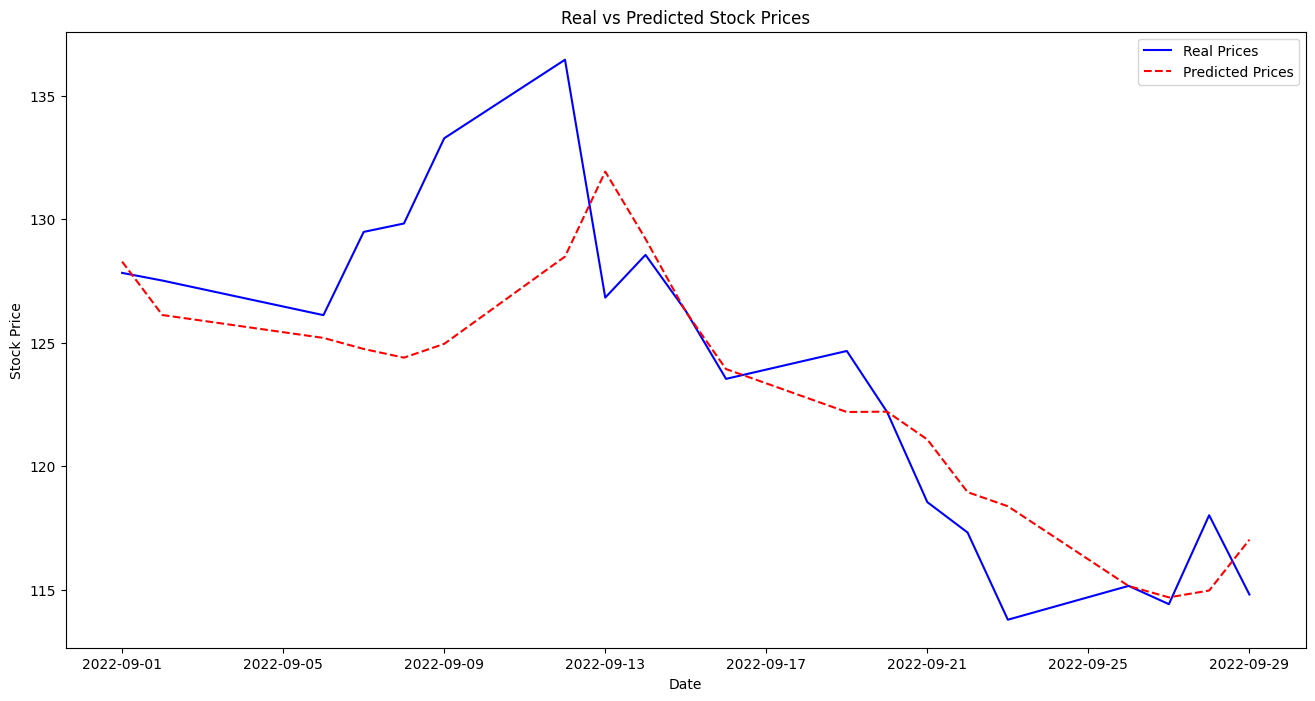

In [11]:
# Plot Test Results
def plot_test_data(y_true, y_pred, index_test):
    """
    Plots the test results (real vs. predicted prices).

    Args:
        y_true (numpy.ndarray): Real stock prices for test data.
        y_pred (numpy.ndarray): Predicted stock prices by the LSTM model.
        index_test (numpy.ndarray): Index for the test data.
    """
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    rescaled_y_true = y_scaler.inverse_transform(y_true)
    rescaled_y_pred = y_scaler.inverse_transform(y_pred)

    plt.figure(figsize=(16, 8))
    plt.plot(index_test, rescaled_y_true, label="Real Prices", color="blue")
    plt.plot(index_test, rescaled_y_pred, label="Predicted Prices", color="red", linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.title("Real vs Predicted Stock Prices")
    plt.show()

# Plot Results
plot_test_data(y_test, y_pred, index_test)

In [12]:
# Evaluate Performance
metrics = evaluate_model(y_test, y_pred, index_test)



Mean Squared Error (MSE): 13.2465
Mean Absolute Percentage Error (MAPE): 0.0207
Root Mean Squared Error (RMSE): 3.6396
